In [1]:
%load_ext autoreload
%autoreload 2

## Fist, get the HTML

In [2]:
#import requests
#page = requests.get('http://www.alias-production.fr/agenda/')
#page_content = page.text
page_content = open('samples/alias-production.Agenda.html').read()

We can list the repeating tagpaths, with or without classes or HTML IDs:

In [33]:
from collections import Counter
from sketchtml.repeats import TagPathClustering


clustering = TagPathClustering(page_content,
                               with_id=False,
                               with_classes=True,
                               strip_digits=False,
                               ignore_classes=('other', 'rock', 'indie', 'pop',
                                               'rock', 'paris_area', 'folk', 'jazz',
                                               'pop-rock', 'hip-hop', 'soul', 'pop-folk',
                                               'funk', 'punk', 'post-punk', 'alternative', 'blues',
                                               'r-b', 'rap', 'electro', 'trip-hop',
                                               'garage', 'psyche', 'experimental', 'ska', 'post-rock', 'mbalax',
                                              'dispo_Ouverte', 'dispo_Complet'),
                              )
clustering._build_tagpaths()

for tp, cnt in Counter(clustering.tagpaths).most_common():
    if cnt > 0:
        print('({:3d}) {}'.format(cnt, tp))

(491) /html/body/div/div.contentPopin/div.wrapStep02/form/div.wrapContentLeft/div.contentColArtistes.contentScrollable/div.colArtistes/div.lineCheckbox
(491) /html/body/div/div.contentPopin/div.wrapStep02/form/div.wrapContentLeft/div.contentColArtistes.contentScrollable/div.colArtistes/div.lineCheckbox/input
(491) /html/body/div/div.contentPopin/div.wrapStep02/form/div.wrapContentLeft/div.contentColArtistes.contentScrollable/div.colArtistes/div.lineCheckbox/label.labelCustomCheckbox
(153) /html/body/div/div.col_center/div.boxMois/div.evenement
(153) /html/body/div/div.col_center/div.boxMois/div.evenement/img.attachment-thumbnail
(153) /html/body/div/div.col_center/div.boxMois/div.evenement/div.date
(153) /html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.day
(153) /html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.month
(153) /html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.year
(153) /html/body/div/div.col_center/div.boxMois/d

## Clustering of tagpaths

Perform spectral clustering using the methom from ["Extracting Data Records from the Web Using Tag Path Clustering", 2009](http://www2009.wwwconference.org/proceedings/pdf/p981.pdf).

> Miao, Gengxin & Tatemura, Junichi & Hsiung, Wang-Pin & Sawires, Arsany & Moser, Louise. (2009).
> **Extracting data records from the Web using tag path clustering**. ACM WWW. 981-990. 10.1145/1526709.1526841.

In [34]:
clusters = clustering.clusters()

## Plotting tagpaths "signals" can help chosing better `with_classes`, `with_ids` parameters

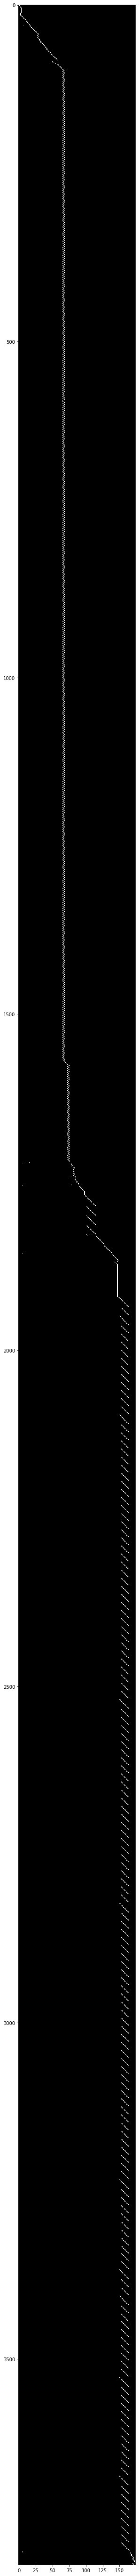

In [35]:
clustering.simhelper.plot_signals()

In [36]:
from pprint import pprint as pp

pp(clusters)

defaultdict(<class 'list'>,
            {0: ['/html/body/div/div.col_center/div.boxMois',
                 '/html/body/div/div.col_center/div.boxMois/div.titleMois',
                 '/html/body/div/div.col_center/div.boxMois/div.titleMois/span',
                 '/html/body/div/div.sidebar/div.filters/ul.listFilters/li.selectFilter',
                 '/html/body/div/div.sidebar/div.filters/ul.listFilters/li.selectFilter/div.selectedValue',
                 '/html/body/div/div.sidebar/div.filters/ul.listFilters/li.selectFilter/div.subFilter'],
             1: ['/html/body/div',
                 '/html/body/div/div',
                 '/html/body/div/div.calendar/div.view/div.calendar/div.notday',
                 '/html/body/div/div.calendar/div.view/div.menu/div.prochainsConcerts/form/select/option',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.date',
                 '/html/bod

## Let's build a trie to reconstruct the layout from a tagpath list (from one or more clusters or a chosen subset of tagpaths)

In [37]:
from functools import partial
from typing import Tuple
from pprint import pformat

_node_repr = partial(TagPathClustering.node_repr,
                             with_classes=True,
                             with_id=False,
                             with_attr_names=False,
                             strip_digits=False)
_node_repr = clustering._node_repr
# This if borrowed from https://towardsdatascience.com/implementing-a-trie-data-structure-in-python-in-less-than-100-lines-of-code-a877ea23c1a1

class TrieNode(object):
    """
    Our trie node implementation. Very basic. but does the job
    """
    
    def __init__(self, char_repr):
        self.char_repr = char_repr
        self.elements = set()
        self.children = []
        # Is it the last character of the word.`
        self.word_finished = False
        # How many times this character appeared in the addition process
        self.counter = 1

def add(root, word):
    """
    Adding a word in the trie structure
    """
    node = root
    #print('Root: {}, Word: {}'.format(root, word))
    for char in word:
        char_repr = _node_repr(char)
        #print('Char: {}'.format(char_repr))
        found_in_child = False
        # Search for the character in the children of the present `node`
        for child in node.children:
            if child.char_repr == char_repr:
                # We found it, increase the counter by 1 to keep track that another
                # word has it as well
                child.counter += 1
                # And point the node to the child that contains this char
                node = child
                found_in_child = True
                #print('Child found.')
                node.elements.add(char)
                break
        # We did not find it so add a new chlid
        if not found_in_child:
            new_node = TrieNode(char_repr)
            new_node.elements.add(char)
            node.children.append(new_node)
            # And then point node to the new child
            node = new_node
            #print('Child NOT found. Creating new TrieNode({})'.format(char))
    # Everything finished. Mark it as the end of a word.
    node.word_finished = True

To help chose the clusters we need, we can print out some of the text data for each tagpath in each cluster.

In [38]:
from pprint import pprint

for n, cluster in sorted(clusters.items()):
    if len(cluster) < 3:
        continue

    print('---- Cluster #{} ----'.format(n))
    for tp in sorted(cluster, key=lambda tp: tp.split('/')):
        to_print = []
        try:
            for nodepath in clustering.tagpath_nodes[tp][:10]:
                node = nodepath[-1]
                e = node.element
                texts = [s.strip() for s in e.xpath('./text()[normalize-space()]')]
                attribs = {k: v for k, v in e.attrib.items() if k not in ['class']}
                t = ' '.join(texts)
                #if t or attribs:
                if t:
                    to_print.append((node.doc_order, t, attribs))
            if to_print:
                print('---\n'+tp)
                for e in to_print:
                    print(e)
                print()
        except Exception as e:
            print(str(e))
            pass

---- Cluster #0 ----
---
/html/body/div/div.col_center/div.boxMois/div.titleMois/span
(1941, 'décembre 2018', {})
(1968, 'janvier 2019', {})
(2115, 'février 2019', {})
(2538, 'mars 2019', {})
(2841, 'avril 2019', {})
(3252, 'mai 2019', {})
(3386, 'juin 2019', {})
(3425, 'juillet 2019', {})
(3546, 'novembre 2019', {})
(3693, 'décembre 2019', {})

---
/html/body/div/div.sidebar/div.filters/ul.listFilters/li.selectFilter/div.selectedValue
(1879, 'Toutes les villes', {})
(1887, 'Style', {})

---- Cluster #1 ----
---
/html/body/div/div
(1771, 'Connexion / Inscription', {'id': 'connect'})

---
/html/body/div/div.calendar/div.view/div.menu/div.prochainsConcerts/form/select/option
(1859, 'Toutes les villes', {'value': ''})
(1860, 'Paris', {'value': 'paris'})
(1861, 'Autres villes', {'value': 'autre'})

---
/html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.day
(1945, '19', {})
(1957, '21', {})
(1972, '11', {})
(1984, '11', {})
(1996, '12', {})
(2008, '16', {})
(2020, '18', {

In [39]:
root = TrieNode('')
nodelists = clustering.tagpath_nodes
tps = []
for i in [3]:
    for tp in clusters[i]:
        tps.append(tp)
tps

['/html/body/div/div.contentPopin/div.wrapStep01/div.wrapContentLeft/form.formMustBeChecked/div.colFormLeft/div.lineCheckbox',
 '/html/body/div/div.contentPopin/div.wrapStep01/div.wrapContentLeft/form.formMustBeChecked/div.colFormLeft/div.lineCheckbox/input.customCheckbox.require-one-chk',
 '/html/body/div/div.contentPopin/div.wrapStep01/div.wrapContentLeft/form.formMustBeChecked/div.colFormLeft/div.lineCheckbox/label.labelCustomCheckbox']

In [40]:
tps = [
                     '/html/body/div/div.col_center/div.boxMois/div.evenement',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.date',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.day',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.month',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.date/span.year',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.nom',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.reservation',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.reservation/br',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.reservation/div.buton',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.reservation/span.nameSalle',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/div.reservation/span.nameVille',
                 '/html/body/div/div.col_center/div.boxMois/div.evenement/img.attachment-thumbnail',
]

Now let's insert them into the trie:

In [41]:
root = TrieNode('')
for tp in tps:
    steps = tp.lstrip('/').split('/')
    for nl in nodelists[tp][:]:
        add(root, nl)

In [42]:
def layout(node, summary=True):
    return dict(
        tag=node.char_repr if node.char_repr else node.char_repr,
        element=len(set(node.elements)) if summary else set(node.elements),
        children=[layout(c, summary=summary) for c in node.children],
        word_finished=node.word_finished
    )

If we check the general structure of the trie, we can notice that some levels only have 1 child.

In [43]:
def collapse(trienode):
    for c in trienode.children:
        collapse(c)
    if len(trienode.children) == 1 and not trienode.word_finished:
        trienode.char_repr += '/'+trienode.children[0].char_repr
        trienode.elements = trienode.children[0].elements
        
        trienode.children = trienode.children[0].children

In [44]:
collapse(root)
layout(root)

{'tag': '/html/body/div/div.col_center/div.boxMois/div.evenement',
 'element': 153,
 'children': [{'tag': 'div.date',
   'element': 153,
   'children': [{'tag': 'span.day',
     'element': 153,
     'children': [],
     'word_finished': True},
    {'tag': 'span.month',
     'element': 153,
     'children': [],
     'word_finished': True},
    {'tag': 'span.year',
     'element': 153,
     'children': [],
     'word_finished': True}],
   'word_finished': True},
  {'tag': 'div.nom', 'element': 153, 'children': [], 'word_finished': True},
  {'tag': 'div.reservation',
   'element': 153,
   'children': [{'tag': 'br',
     'element': 153,
     'children': [],
     'word_finished': True},
    {'tag': 'div.buton',
     'element': 150,
     'children': [],
     'word_finished': True},
    {'tag': 'span.nameSalle',
     'element': 153,
     'children': [],
     'word_finished': True},
    {'tag': 'span.nameVille',
     'element': 153,
     'children': [],
     'word_finished': True}],
   'word_f

We can collapse those branches:

The trie also keeps references to individual HTML nodes, with their document order so that we can re-build the data hierarchy:

In [45]:
layout(root, summary=False)

{'tag': '/html/body/div/div.col_center/div.boxMois/div.evenement',
 'element': {Node(tag='div', doc_order=1942, child_position=2, attribs={'class': '  other evenement', 'onclick': "window.location = 'http://www.alias-production.fr/concerts/terrenoire/?date=20181219';"}, element=<Element div at 0x7fc5d7d87748>),
  Node(tag='div', doc_order=1954, child_position=3, attribs={'class': '  other evenement', 'onclick': "window.location = 'http://www.alias-production.fr/concerts/terrenoire/?date=20181221';"}, element=<Element div at 0x7fc5d7d87a88>),
  Node(tag='div', doc_order=1969, child_position=2, attribs={'class': '  other folk  evenement', 'onclick': "window.location = 'http://www.alias-production.fr/concerts/safia-nolin/?date=20190111';"}, element=<Element div at 0x7fc5d7d87e48>),
  Node(tag='div', doc_order=1981, child_position=3, attribs={'class': '   paris_area  evenement', 'onclick': "window.location = 'http://www.alias-production.fr/concerts/a-definir-dans-un-futur-proche/?date=2019

## Re-creating data hierarchy

Below is the most interesting bit: how to re-create a dict/JSON document from repeating tagpaths.

Using the trie, from the root of the tree, we loop over all HTML elements of a trie node, and recursively collect data from its children:

In [50]:
from collections import defaultdict
from operator import itemgetter
from lxml.html import tostring


def hydrate(node, docorder_min, docorder_max=None, include_html=False):
    elements = sorted(set(node.elements), key=lambda n: n.doc_order)
    output = []

    for i, element in enumerate(elements, start=1):
        
        # filter out elements that are not within the parent document order range
        if not (docorder_min < element.doc_order):
            continue
        if (docorder_max is not None) and (element.doc_order > docorder_max):
            continue
        
        # here's where you extract data from the element
        # 1. node representation including tag and classes can tell us a bit about what it's about
        # 2. document order is purely informational
        # 3. child text nodes usually contain much of the information we want
        # 4. element attributes also can be useful (URL, data-* etc.)
        e = {'tag': _node_repr(element),
             '_doc_order': element.doc_order}
        
        # textual information
        _t = list(filter(bool, [t.strip() for t in element.element.xpath('./text()[normalize-space()]')]))
        if _t:
            e['text'] = _t[0] if len(_t) == 1 else _t
        _html = tostring(element.element, encoding='unicode')
        if _html:
            #e['html'] = _html
            pass
            
        _attrib = dict(element.element.attrib)
        if 'class' in _attrib:
            _attrib.pop('class')
        if _attrib:
            e['_attr'] = _attrib
        
        # loop through sub-nodes that are between the current node and the next one
        # Warning: recursivity!
        _order_min = element.doc_order
        if i < len(elements):
            _order_max = elements[i].doc_order
        else:
            _order_max = None
        children = list(filter(bool, [c for child in node.children
                                      for c in hydrate(child, _order_min, _order_max)]))
        if children:
            e['children'] = sorted(children, key=itemgetter('_doc_order'))
            #e['children'] = children
        
        # if there's not "valuable" information, might as well skip the element
        if 'children' not in e and not(any(e.get(k) for k in ['text', '_attr'])):
            continue

        output.append(e)
        
    #return sorted(output, key=itemgetter('_doc_order'))
    return output

output = hydrate(root, 0)
pp(output)

[{'_attr': {'onclick': 'window.location = '
                       "'http://www.alias-production.fr/concerts/terrenoire/?date=20181219';"},
  '_doc_order': 1942,
  'children': [{'_attr': {'alt': 'TERRENOIRE',
                          'height': '270',
                          'src': 'http://www.alias-production.fr/wp-content/uploads/2018/06/terrenoire-vignette1.jpg',
                          'width': '260'},
                '_doc_order': 1943,
                'tag': 'img.attachment-thumbnail'},
               {'_doc_order': 1944,
                'children': [{'_doc_order': 1945,
                              'tag': 'span.day',
                              'text': '19'},
                             {'_doc_order': 1946,
                              'tag': 'span.month',
                              'text': 'DEC.'},
                             {'_doc_order': 1947,
                              'tag': 'span.year',
                              'text': '2018'}],
                'tag':

The output data seems to present all the data we'd need for something like PyVideo.org.

Let's just save for further processing.

In [24]:
import json

JSON_FORMAT_KWARGS = {
    'indent': 2,
    'separators': (',', ': '),
    'sort_keys': True,
}
with open('pydata-berlin-2015.speakers.json', 'w') as fp:
    json.dump(output, fp, **JSON_FORMAT_KWARGS)
    fp.write("\n")

## Is there a way to automatically chose clusters?

Spectral clustering does not always give the "best" results. It may be due to the similarity function, or some other parameters, I don't know yet really.

Below is a just to see if hierarchical clustering of tagpaths would do a better job.

In [25]:
simhelper = clustering.simhelper

In [27]:
from itertools import zip_longest, combinations
from collections import Counter

import numpy as np

tagpaths = [
    tp for tp, cnt in Counter(clustering.tagpaths).most_common()
    if cnt > 1
]

l = len(tagpaths)
matrix = np.zeros((l, l))

for a, b in combinations(tagpaths, 2):
    ia, ib = tagpaths.index(a), tagpaths.index(b)
    try:
        matrix[ia, ib] = 1 - simhelper.similarity(a, b, epsilon=10)
    except:
        matrix[ia, ib] = 1
    matrix[ib, ia] = matrix[ia, ib]
    matrix[ia, ia] = 0
    matrix[ib, ib] = 0

In [28]:
from sklearn.cluster import AgglomerativeClustering

clustering2 = AgglomerativeClustering(n_clusters=l, affinity='precomputed', linkage='average')

clustering2.fit_predict(matrix)

array([35, 29, 26, 30, 18, 31, 25, 32, 24, 33, 23, 34, 15, 17, 27, 28, 22,
       13, 21, 11, 16, 10,  8, 20, 19,  9, 14,  6, 12,  7,  5,  4,  3,  1,
        2,  0])

In [29]:
# Authors: Mathew Kallada
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================

This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

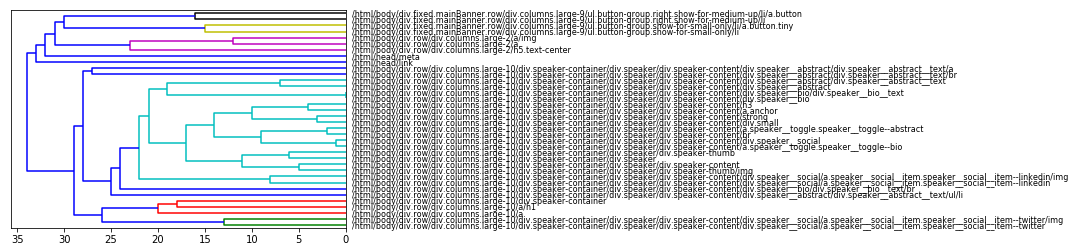

In [30]:
ax = plt.plot()
plot_dendrogram(clustering2, labels=tagpaths, orientation='left'
                , leaf_font_size=8
               )